# Model of image sampling system

First step to removal of distortions is understanding how they happen.

If we consider a generic digital camera then they are two sources of distortions:

 - Stochastic Poisson noise (shot noise).
 - Deterministic distortions.

Deterministic distortions are modelled using a convolution with a kernel. That kernel is usuall called a point spread function of a system.

This leads us to the following equation that models our image sampling system:

$$
D(x, y) = (I * P)(x, y) + N(x, y)
$$

Where $D(x, y)$ is what we are getting out of the detector, $I(x,y)$ is signal that we want to have, $P(x,y)$ is a convolution kernel that modells deterministic ditortions caused by sampling system and $N(x,y)$ is a Poisson noise.

# Deconvolution problem

Considering the above model our problem of image enhacement is a problem of finding $I$ having $D$ and $P$.

Unfortunately, the above equation will be mathematically ill-posed, i.e. its solution may
not exist, may not be unique and may be unstable with respect, to small perturbations of "input" data $D$, $P$ and $N$.

This is easy to be shown in the frequency domain. In frequency domain our image sampling model look's like this:

$$
\hat{D}(\omega) = \hat{I}(\omega)\hat{P}(\omega) + \hat{N}(\omega)
$$

That means that a solution for finding $\hat{I}(\omega)$ is:

$$
\hat{I}(\omega) = \frac{\hat{D}(\omega) - \hat{N}(\omega)}{\hat{P}(\omega)}
$$

This formula has some consequences:

If $\hat{P}(\omega) = 0$ solution also does not exist.

Also solution will be unstable if $\hat{P}(\omega)$ is small.

Now we will demonstrate a naive solution that we already know it's ill posed.
But let's see what happend.

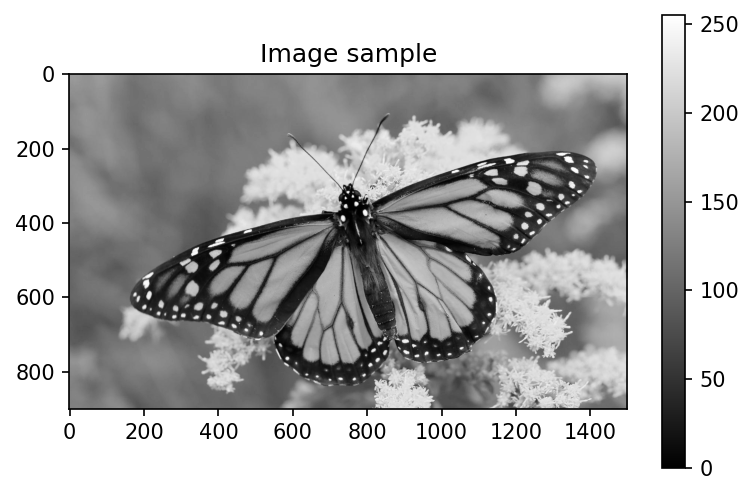

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 150

sample = cv2.imread("../samples/monarch.jpg", cv2.IMREAD_GRAYSCALE)

plt.title("Image sample")
plt.imshow(sample, cmap='gray')
plt.colorbar()
#plt.savefig('1_initial_sample.png', dpi=300)  

Now let's generate a gaussian kernel and convolve our image with it.

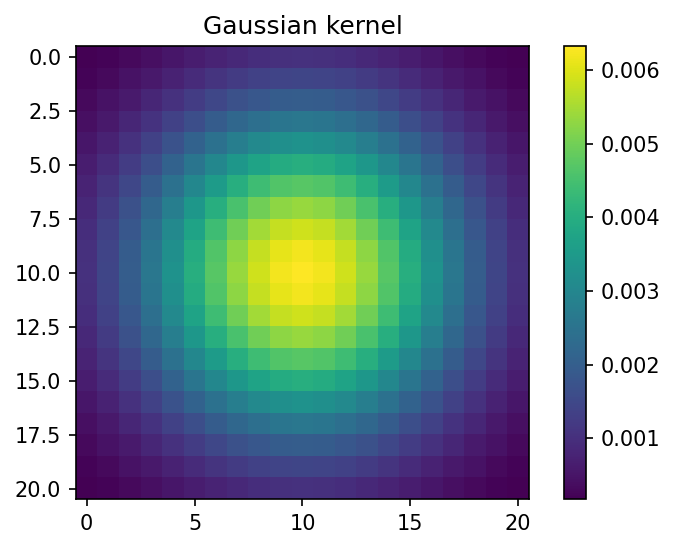

In [2]:
import numpy as np
import scipy.stats as st

def gen_gauss(kernlen=21, nsig=2):
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

gaussian_kernel = gen_gauss()
plt.title("Gaussian kernel")
plt.imshow(gaussian_kernel)
plt.colorbar()
#plt.savefig('1_gaussian.png', dpi=300)  

First we need to zero pad a kernel so it has the same size as image.

In [3]:
def zero_pad_img_to_kernel(img, kernel):
    # Prepare zero padded kernel.
    kernel_new = np.zeros(img.shape)
    
    # compute center offset
    kernel_new[0:kernel.shape[0], 0:kernel.shape[1]] = kernel
    
    return kernel_new

In [4]:
kernel_new = zero_pad_img_to_kernel(sample, gaussian_kernel)

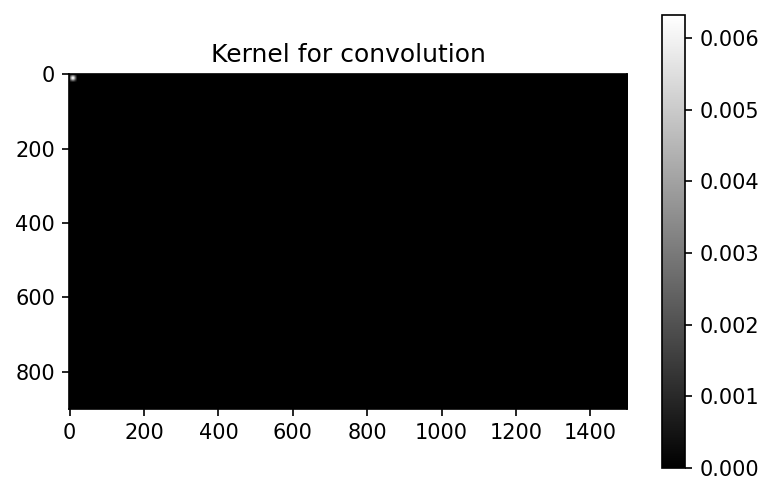

In [5]:
plt.title("Kernel for convolution")
plt.imshow(kernel_new, cmap='gray')
plt.colorbar()

Now let's perform the FFT of those two signal and make a convolution (multiplication in frequency domain).

In [6]:
from numpy.fft import fft2, ifft2

sample_fft = fft2(sample)
kernel_new_fft = fft2(kernel_new)
blurred_fft = sample_fft*kernel_new_fft
blurred = ifft2(blurred_fft)
blurred = blurred.real

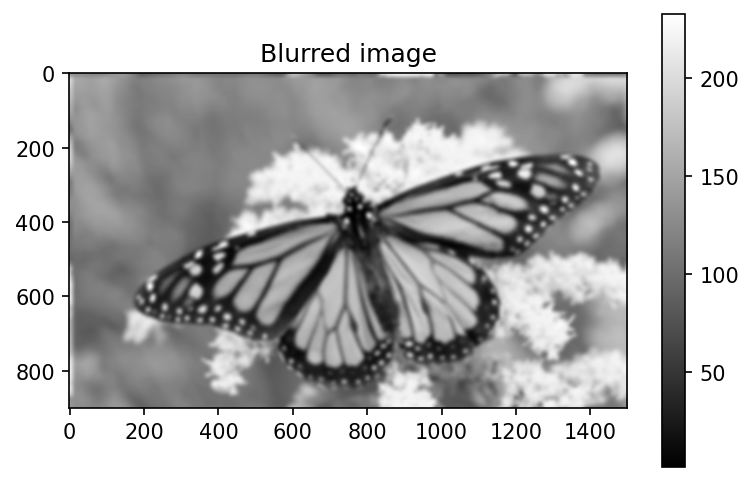

In [7]:
plt.title("Blurred image")
plt.imshow(blurred, cmap='gray')
plt.colorbar()
#plt.savefig('1_blurred.png', dpi=300)

Now let's attempt deconvolution by taking the spectrum of the convolved signal and dividing by the spectrum of the gaussian function.

In [8]:
def deconvolve(kernel, img):
    padded_kernel_fft = fft2(zero_pad_img_to_kernel(img, kernel))
    img_fft = fft2(img)
    deblurred = ifft2(img_fft/padded_kernel_fft)
    return deblurred.real[gaussian_kernel.shape[0]:, gaussian_kernel.shape[1]:]

In [9]:
deblurred = deconvolve(gaussian_kernel, blurred)

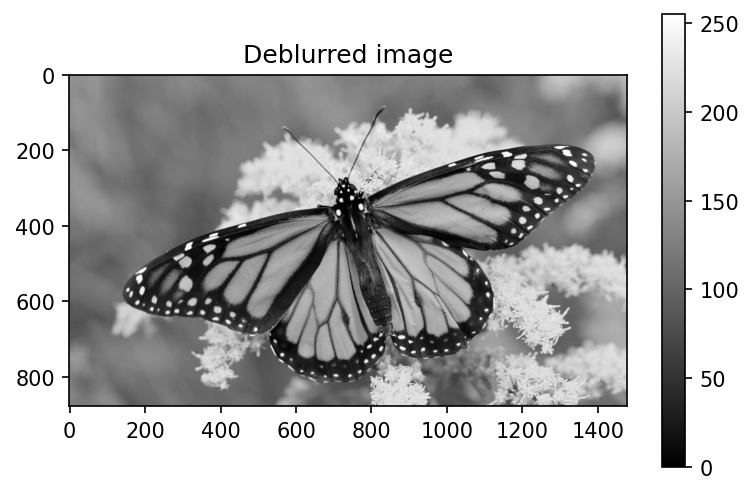

In [10]:
plt.title("Deblurred image")
plt.imshow(deblurred, cmap='gray')
plt.colorbar()
#plt.savefig('1_unblurred.png', dpi=300)

It works!

# The effects of noise

Now let's add noise to the image and see how naive method will perform.

In [11]:
def add_gaussian_noise(img, sigma):
	gauss = np.random.normal(0, sigma, np.shape(img))
	noisy_img = img + gauss
	noisy_img[noisy_img < 0] = 0
	noisy_img[noisy_img > 255] = 255
	return noisy_img

sample_noisy = add_gaussian_noise(sample, 20)

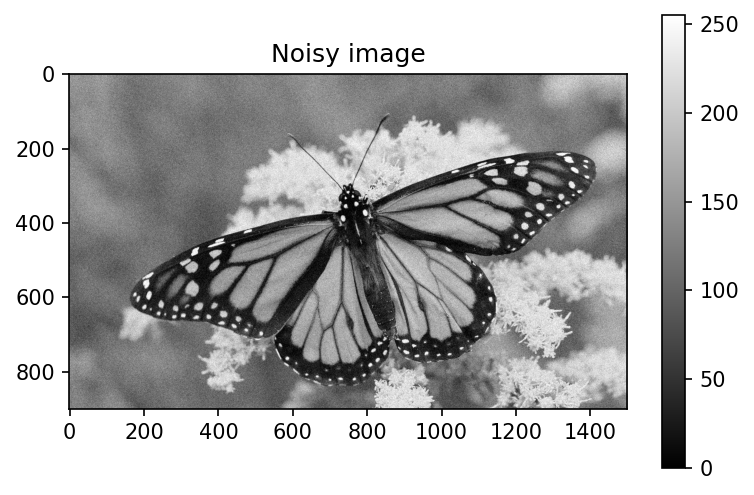

In [12]:
plt.title("Noisy image")
plt.imshow(sample_noisy, cmap='gray')
plt.colorbar()
#plt.savefig('1_noisy.png', dpi=300)

In [13]:
sample_noisy_fft = fft2(sample_noisy)
blurred_noisy_fft = sample_noisy_fft*kernel_new_fft
blurred_noisy = ifft2(blurred_noisy_fft)
blurred_noisy = blurred_noisy.real[gaussian_kernel.shape[0]:, gaussian_kernel.shape[1]:]

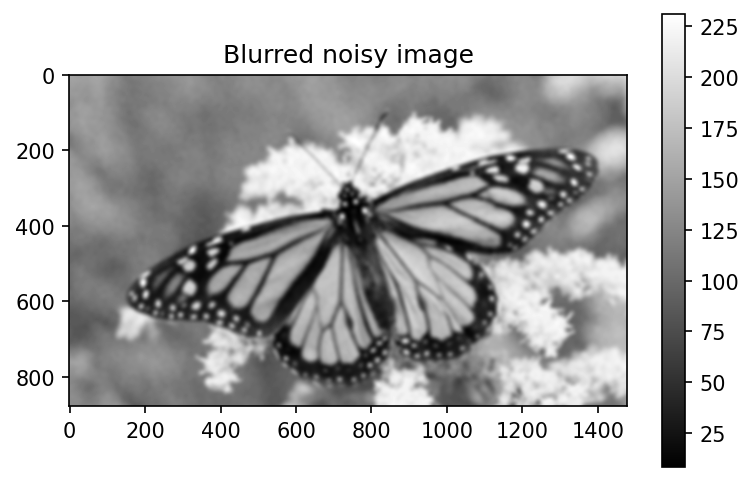

In [14]:
plt.title("Blurred noisy image")
plt.imshow(blurred_noisy, cmap='gray')
plt.colorbar()
#plt.savefig('1_noisy_blurred.png', dpi=300)

In [15]:
deblurred_noisy = deconvolve(gaussian_kernel, blurred_noisy)

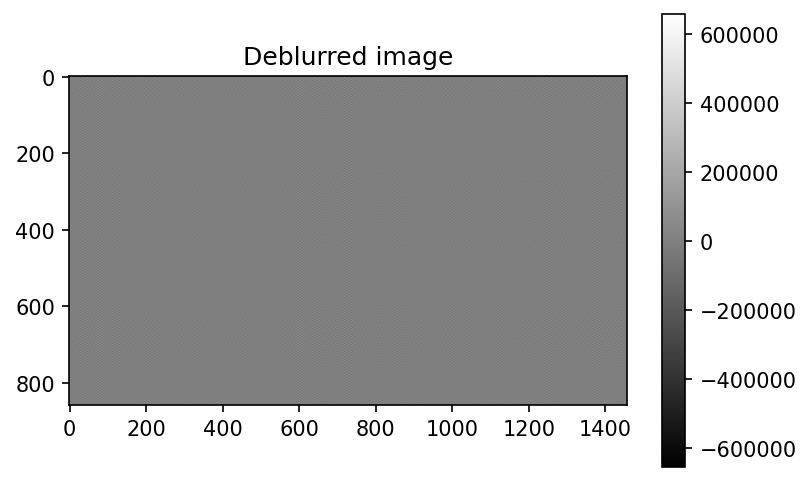

In [16]:
plt.title("Deblurred image")
plt.imshow(deblurred_noisy, cmap='gray')
plt.colorbar()
#plt.savefig('1_noisy_deblurred.png', dpi=300)

As we can see addition of noise caused noise explosion.

# Regularization as a solution to noise problem

The problem with the noise is that we wanted to do this.

$$
\hat{I}(\omega) = \frac{\hat{D}(\omega) - \hat{N}(\omega)}{\hat{P}(\omega)}
$$

But in reality, during deconvolution we do not know the noise so we cannot substract it.

It is an integral part of input image $\hat{D}(\omega)$.

So what are we doing look's like this instead:

$$
\hat{f}(\omega) = \frac{\hat{y}(\omega)}{\hat{h}(\omega)}
$$

Where $\hat{f}(\omega)$ is image that we are getting from deconvolution, $\hat{y}(\omega)$ is
input image with noise and $\hat{h}(\omega)$ is a known conwolution kernel. All in frequency domain.

Notice the lack of noise.

That means that in reality we are doing:

$$
\hat{I}(\omega) = \frac{\hat{D}(\omega) + \hat{N}(\omega)}{\hat{P}(\omega)} = 
$$

$$
= \frac{\hat{D}(\omega)}{\hat{P}(\omega)} + \frac{\hat{N}(\omega)}{\hat{P}(\omega)}
$$

The problem with this is that very small variations of the noise are producing large variations of the output signal.
In other words the noise is greatly amplified to the point that it overwhelms anything else.

We can attempt to solve this problem by performing a regularization. Regularization imposes additional constrains on the output of the deconvolution.

## L2

First we can perform L2 regularizations which penalizes high values of the result.
Leaving math magic used to derive this aside, here is a ready to use formula for deconvolution that results
in the lowest value of L2 regularization term.

$$
\hat{f}(\omega) = \frac{\hat{y}(\omega) \hat{h}(\omega)}
{||\hat{h}(\omega)||^2 + \lambda }
$$

$\lambda$ is a regularization factor. The higher the value the stronger the regularization.

In [17]:
def deconvolve_l2(kernel, img, lambd):
    padded_kernel_fft = fft2(zero_pad_img_to_kernel(img, kernel))
    img_fft = fft2(img)
    deblurred_fft = (img_fft*padded_kernel_fft)/(np.absolute(padded_kernel_fft)**2 + lambd)
    deblurred = ifft2(deblurred_fft)
    return deblurred.real[gaussian_kernel.shape[0]:, gaussian_kernel.shape[1]:]

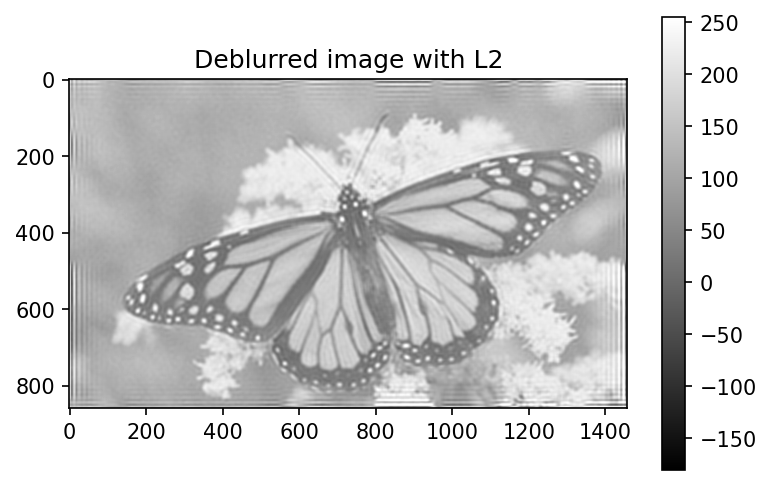

In [18]:
deblurred_noisy_l2 = deconvolve_l2(gaussian_kernel, blurred_noisy, 0.001)
deblurred_noisy_l2[deblurred_noisy_l2>255] = 255
plt.title("Deblurred image with L2")
plt.imshow(deblurred_noisy_l2, cmap='gray')
plt.colorbar()
#plt.savefig('1_l2_deblurred.png', dpi=300)

They are also other regularizations possible but we will not discuss them further.

# Deconvolution methods

We have two cathegories of the deconvolution methods.

 - Direct methods
 - Indirect methods

Direct methods simply perform deconvolution by division of spectrum. Generally they are fast but sensitive to noise as was demonstrated before.
They are also bad at in incorporating available a priori information.

Indirect methods perform (parametric) modelling, solve the forward problem
(convolution) and minimize a cost function. They have better treatment of noise, easy incorporation of
available a priori information but they are also slower since they often use iterative methods that require many steps to converge.